In [1]:
# data processing
import numpy as np
import pandas as pd
pd.options.display.max_rows = 7
# plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline
# interactivity
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# statistics
import statsmodels.api as sm
from scipy import stats

In [2]:
# presetting
rawDataFile = 'PerformanceData_2019.xlsx'
flag_log = False
timeStart = pd.Timestamp(year=2019, month=1, day=25)
yearDays = 252

# 0. Data Preparation
## 0.1 Load raw data

In [3]:
# load raw data
df_raw = pd.read_excel(rawDataFile)

# floor the date for further aggregation
df_raw['date'] = df_raw['date'].dt.floor('d')

# print
#print('\n\nShow the raw data:')
#df_raw
#print('\n\nData types:')
#df_raw.dtypes

* Notice that the dtype is already datetime64\[ns\]! So I do not need to convert it into datetime.
* The first five columns' names shown here are not complete.

## 0.2 Get *STI*

In [4]:
df_STI = df_raw.iloc[:38,[0, 9]].copy()
df_STI['Name']    = 'STI'
df_STI['groupid'] = 'STI'
df_STI = df_STI.rename({'STI':'total'}, axis='columns')
df_STI = df_STI.sort_values(by='date')
df_STI = df_STI[df_STI['date'] >= timeStart].copy()
df_STI

,date,total,Name,groupid
0,2019-01-25,3202.25,STI,STI
1,2019-01-28,3199.50,STI,STI
2,2019-01-29,3187.69,STI,STI
...,...,...,...,...
35,2019-03-20,3207.66,STI,STI
36,2019-03-21,3213.65,STI,STI
37,2019-03-22,3212.10,STI,STI


## 0.3 Get *rf*

In [5]:
df_rf = df_raw.iloc[:38,[0,10]].copy().sort_values(by='date')
df_rf = df_rf[df_rf['date'] >= timeStart].copy()
if flag_log:
    df_rf = np.log(df_rf+1)
df_rf

,date,rf
0,2019-01-25,0.000054
1,2019-01-28,0.000055
2,2019-01-29,0.000055
...,...,...
35,2019-03-20,0.000054
36,2019-03-21,0.000054
37,2019-03-22,0.000054


## 0.4 Get df_indi

In [6]:
df_indi = df_raw.iloc[:,[0,1,2,6]].copy()
df_indi = df_indi[df_indi['date'] >= timeStart].copy()
df_indi

,date,Name,groupid,total
0,2019-01-25,Chen Junkang,M 01,1000000.00
1,2019-01-28,Chen Junkang,M 01,1000000.00
2,2019-01-29,Chen Junkang,M 01,1000000.00
...,...,...,...,...
1137,2019-03-20,Zhang Zhao,M 06,1001033.52
1138,2019-03-21,Zhang Zhao,M 06,1002933.52
1139,2019-03-22,Zhang Zhao,M 06,1000983.52


## 0.5 Get *df_team*
We could directly floor date and sum team value at the same time:
```python
temp = df.groupby([df['groupid'],df['date'].dt.floor('d')]).sum()
```
but the result are suitable to merge to the original df,
so it would be better to floor date in df directly in advance, and we have finished it before.

In [7]:
# group and sum teams' total value
df_team = df_indi.groupby([df_indi['groupid'],df_indi['date']]).sum()
# convert the 2-level hierarchical index into two columns
df_team = df_team.reset_index(['groupid', 'date'])
# add Name
df_team['Name'] = df_team['groupid']
# print
df_team

,groupid,date,total,Name
0,M 01,2019-01-25,5000000.00,M 01
1,M 01,2019-01-28,4994778.25,M 01
2,M 01,2019-01-29,4990319.44,M 01
...,...,...,...,...
225,M 06,2019-03-20,4676476.51,M 06
226,M 06,2019-03-21,4691058.51,M 06
227,M 06,2019-03-22,4672546.51,M 06


## 0.6 Merge df_team, df_indi, and STI into *df*

In [8]:
# merge individual df and team df
df = pd.concat([df_indi,df_team,df_STI], sort = False, ignore_index=True) # sort: Sort non-concatenation axis
# hierarchical indexing
df = df.set_index(['Name','date'])
# print
print('\n\nShow the DataFrame for all individuals and teams:')
df
print('\n\nData types:')
df.dtypes



Show the DataFrame for all individuals and teams:


groupid       total
Name         date                          
Chen Junkang 2019-01-25    M 01  1000000.00
             2019-01-28    M 01  1000000.00
             2019-01-29    M 01  1000000.00
...                         ...         ...
STI          2019-03-20     STI     3207.66
             2019-03-21     STI     3213.65
             2019-03-22     STI     3212.10

[1406 rows x 2 columns]



Data types:


groupid     object
total      float64
dtype: object

# 1. daily returns
for individuals, teams, and STI

In [9]:
# initialize df_1
df_1 = pd.DataFrame(columns=['groupid','dailyReturn'], index=df.index)
# fill the nan
for name, group in df.groupby(level=0):
    group = group.loc[name].sort_values(by = 'date')
    if flag_log:
        df_1.loc[name,'dailyReturn'] = np.concatenate([[np.nan], np.log(group['total'][1:].values/group['total'][:-1].values)])
    else:
        df_1.loc[name,'dailyReturn'] = np.concatenate([[np.nan],group['total'][1:].values/group['total'][:-1].values-1])
    df_1.loc[name,'groupid'] = group['groupid'][0]
# convert dailyReturn to float
df_1['dailyReturn'] = df_1['dailyReturn'].astype(float)
# print
df_1[(df_1['groupid']=='M 03')|(df_1['groupid']=='STI')]
print('\n\nData types:')
df_1.dtypes

groupid  dailyReturn
Name     date                           
Chen Yue 2019-01-25    M 03          NaN
         2019-01-28    M 03     0.000000
         2019-01-29    M 03     0.000000
...                     ...          ...
STI      2019-03-20     STI    -0.004117
         2019-03-21     STI     0.001867
         2019-03-22     STI    -0.000482

[266 rows x 2 columns]



Data types:


groupid         object
dailyReturn    float64
dtype: object

# 2. Returns and Box plot
## 2.1 Returns of the whole horizon (not annualized)

In [10]:
# initialize df_2
df_2 = pd.DataFrame()
# fill the nan
for name, group in df.groupby(level=0):
    group = group.sort_values(by = 'date')
    df_2.loc[name,'groupid'] = group['groupid'].iloc[0]
    if flag_log:
        df_2.loc[name,'whole_return'] = np.log(group['total'].iloc[-1] / group['total'].iloc[0])
    else:
        df_2.loc[name,'whole_return'] = group['total'].iloc[-1] / group['total'].iloc[0] - 1
df_2 = df_2.sort_values(by = 'groupid')
# convert whole_return to float
df_2['whole_return'] = df_2['whole_return'].astype(float)
# print
df_2
print('\n\nData types:')
df_2.dtypes

,groupid,whole_return
Chen Junkang,M 01,0.052776
Zhang Siqi,M 01,0.028815
Chia Kai Peng,M 01,0.005316
...,...,...
Chen Xilin,M 06,-0.025930
Zhang Zhao,M 06,0.000984
STI,STI,0.003076




Data types:


groupid          object
whole_return    float64
dtype: object

## 2.2 Box plot

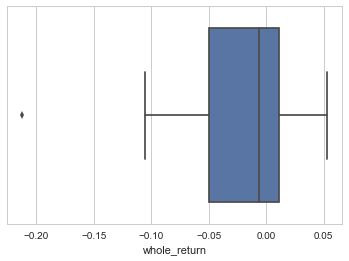

In [11]:
# note that the datatype of df_2["whole_return"] is object, so we need to convert it into float.
ax1 = sns.boxplot(x=df_2["whole_return"])

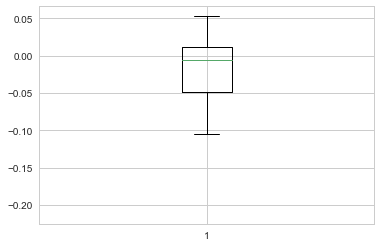

In [12]:
ax2 = plt.boxplot(df_2["whole_return"])

# 3. Jensen’s Alpha (daily return)
## 3.0 Before all
### 3.0.1 names of M03 and STI

In [13]:
# names of M03 and STI
names_M03_STI = []
for name_group in list(df_1[df_1['groupid']=='M 03'].groupby(level=0)):
    names_M03_STI.append(name_group[0])
names_M03_STI.append('STI')

### 3.0.2 averae rf, rp, rm, std(rp-rf), std(rp-rm), and downside_std(rp_rf)

In [14]:
df_new = pd.DataFrame()
l = df_rf['rf'].values[1:].size
if flag_log:
    rf = np.mean(df_rf['rf'].values[1:])
    rm = df_2.loc['STI','whole_return'] / l
else:
    rf = stats.gmean(df_rf['rf'].values[1:] + 1) - 1
    rm = np.power(df_2.loc['STI','whole_return']+1, 1/l) - 1
for name in names_M03_STI:
    if flag_log:
        df_new.loc[name,'rp'] = df_2.loc[name,'whole_return'] / l
    else:
        df_new.loc[name,'rp'] = np.power(df_2.loc[name,'whole_return']+1, 1/l) - 1
    df_new.loc[name,'rf'] = rf
    df_new.loc[name,'rm'] = rm
    df_new.loc[name,'std_rp_rf'] = np.std(df_1.loc[name,'dailyReturn'][1:] - df_rf['rf'].values[1:])
    df_new.loc[name,'std_rp_rm'] = np.std(df_1.loc[name,'dailyReturn'][1:] - df_1.loc['STI','dailyReturn'].values[1:])
    df_new.loc[name,'down_std_rp_rf'] = np.sqrt(np.mean(np.power(np.minimum(df_1.loc[name,'dailyReturn'][1:] - df_rf['rf'].values[1:], 0), 2)))
df_new.loc['STI','std_rp_rm'] = np.nan
df_new

,rp,rf,rm,std_rp_rf,std_rp_rm,down_std_rp_rf
Chen Yue,0.000114,0.000054,0.000083,0.009515,0.009327,0.006969
Im Suyeon,0.000306,0.000054,0.000083,0.005396,0.003803,0.003809
M 03,-0.000156,0.000054,0.000083,0.005454,0.004699,0.004096
Song Shaopu,-0.001103,0.000054,0.000083,0.005698,0.005622,0.004609
Wang Buyu,0.001275,0.000054,0.000083,0.007511,0.006105,0.004504
Zhang Qian,-0.001462,0.000054,0.000083,0.007962,0.007945,0.006989
STI,0.000083,0.000054,0.000083,0.005002,NaN,0.003367


## 3.2 Jensen’s Alpha
$$ Jensen's Alpha = r_p -r_f - \beta_p * (r_m - r_f)$$

In [15]:
df_3 = pd.DataFrame()
for name in names_M03_STI:
    y = (df_1.loc[name,'dailyReturn'].values[1:]  - df_rf['rf'].values[1:]) # 1: is to avoid nan
    x = (df_1.loc['STI','dailyReturn'].values[1:] - df_rf['rf'].values[1:]) # 1: is to avoid nan
    x = sm.add_constant(x)
    results = sm.OLS(y,x).fit()
    #results.summary()
    df_3.loc[name,'alpha']        = results.params[0]
    df_3.loc[name,'beta']         = results.params[1]
    df_3.loc[name,'alpha_pValue'] = results.pvalues[0]
    df_3.loc[name,'beta_pValue']  = results.pvalues[1]
    df_3.loc[name,'mse_resid']    = results.mse_resid
df_3.loc['STI','alpha']        = 0
df_3.loc['STI','beta']         = 1
df_3.loc['STI','alpha_pValue'] = np.nan
df_3.loc['STI','beta_pValue']  = np.nan
df_3.loc['STI','mse_resid']    = np.nan
df_3

,alpha,beta,alpha_pValue,beta_pValue,mse_resid
Chen Yue,0.000081,0.570979,0.957949,7.108648e-02,0.000087
Im Suyeon,0.000233,0.792863,0.708346,2.217605e-07,0.000014
M 03,-0.000223,0.653183,0.764646,8.952336e-05,0.000020
Song Shaopu,-0.001162,0.517193,0.184323,4.767108e-03,0.000027
Wang Buyu,0.001212,0.882436,0.245969,1.311262e-04,0.000039
Zhang Qian,-0.001505,0.505282,0.246185,5.556689e-02,0.000060
STI,0.000000,1.000000,NaN,NaN,NaN


# 4. Treynor Measure (daily return)
$$ Sharpe Ratio = \frac{r_p - r_f}{\beta_p}$$

In [16]:
df_4 = pd.DataFrame()
# loop on names_M03_STI
for name in names_M03_STI:
    df_4.loc[name,'rp']      = df_new.loc[name,'rp']
    df_4.loc[name,'rf']      = df_new.loc[name,'rf']
    df_4.loc[name,'beta']    = df_3.loc[name,'beta']
    df_4.loc[name,'Treynor'] = (df_new.loc[name,'rp'] - df_new.loc[name,'rf']) / df_3.loc[name,'beta']
df_4

,rp,rf,beta,Treynor
Chen Yue,0.000114,0.000054,0.570979,0.000104
Im Suyeon,0.000306,0.000054,0.792863,0.000317
M 03,-0.000156,0.000054,0.653183,-0.000323
Song Shaopu,-0.001103,0.000054,0.517193,-0.002238
Wang Buyu,0.001275,0.000054,0.882436,0.001383
Zhang Qian,-0.001462,0.000054,0.505282,-0.003001
STI,0.000083,0.000054,1.000000,0.000029


# 5. Sharpe Ratio (daily return)
$$ Sharpe Ratio = \frac{r_p - r_f}{\sigma_{(r_p - r_f)}}$$

In [17]:
df_5 = pd.DataFrame()
for name in names_M03_STI:
    df_5.loc[name,'rp']        = df_new.loc[name,'rp']
    df_5.loc[name,'rf']        = df_new.loc[name,'rf']
    df_5.loc[name,'std_rp_rf'] = df_new.loc[name,'std_rp_rf']
    df_5.loc[name,'Sharpe']    = (df_new.loc[name,'rp'] - df_new.loc[name,'rf']) / df_new.loc[name,'std_rp_rf']
df_5

,rp,rf,std_rp_rf,Sharpe
Chen Yue,0.000114,0.000054,0.009515,0.006260
Im Suyeon,0.000306,0.000054,0.005396,0.046564
M 03,-0.000156,0.000054,0.005454,-0.038649
Song Shaopu,-0.001103,0.000054,0.005698,-0.203097
Wang Buyu,0.001275,0.000054,0.007511,0.162459
Zhang Qian,-0.001462,0.000054,0.007962,-0.190464
STI,0.000083,0.000054,0.005002,0.005713


# 6. Information Ratio (daily return)
$$ Information Ratio = \frac{r_p - r_{m}}{\sigma_{(r_p - r_{m})}}$$

In [18]:
df_6 = pd.DataFrame()
for name in names_M03_STI:
    if name == 'STI':
        continue
    df_6.loc[name,'rp']        = df_new.loc[name,'rp']
    df_6.loc[name,'rm']        = df_new.loc[name,'rm']
    df_6.loc[name,'std_rp_rm'] = df_new.loc[name,'std_rp_rm']
    df_6.loc[name,'Info']      = (df_new.loc[name,'rp'] - df_new.loc[name,'rm']) / df_new.loc[name,'std_rp_rm']
df_6

,rp,rm,std_rp_rm,Info
Chen Yue,0.000114,0.000083,0.009327,0.003322
Im Suyeon,0.000306,0.000083,0.003803,0.058557
M 03,-0.000156,0.000083,0.004699,-0.050940
Song Shaopu,-0.001103,0.000083,0.005622,-0.210925
Wang Buyu,0.001275,0.000083,0.006105,0.195176
Zhang Qian,-0.001462,0.000083,0.007945,-0.194459


# 7. $M^2$ Measure (daily return)
$$ M^2 Measure = Sharpe Ratio * \sigma_{(r_p - r_{m})} + r_f$$

In [19]:
df_7 = pd.DataFrame()
for name in names_M03_STI:
    if name == 'STI':
        continue
    df_7.loc[name,'rf']        = df_new.loc[name,'rf']
    df_7.loc[name,'Sharpe']    = df_5.loc[name,'Sharpe']
    df_7.loc[name,'std_rp_rm'] = df_new.loc[name,'std_rp_rm']
    df_7.loc[name,'M2']        = df_5.loc[name,'Sharpe'] * df_new.loc[name,'std_rp_rm'] + df_new.loc[name,'rf']
df_7

,rf,Sharpe,std_rp_rm,M2
Chen Yue,0.000054,0.006260,0.009327,0.000113
Im Suyeon,0.000054,0.046564,0.003803,0.000232
M 03,0.000054,-0.038649,0.004699,-0.000127
Song Shaopu,0.000054,-0.203097,0.005622,-0.001087
Wang Buyu,0.000054,0.162459,0.006105,0.001046
Zhang Qian,0.000054,-0.190464,0.007945,-0.001459


# 8. Sortino Measure (daily return)
$$ Sortino Measure = \frac{r_p - r_f}{DownsideDeviation_{(r_p - r_f)}}$$
$$ Downside Deviation = \sqrt{\frac{1}{n}\sum_{r_p<r_f}^n(r_p-r_f)^2}$$

In [20]:
df_8 = pd.DataFrame()
for name in names_M03_STI:
    df_8.loc[name,'rp']             = df_new.loc[name,'rp']
    df_8.loc[name,'rf']             = df_new.loc[name,'rf']
    df_8.loc[name,'down_std_rp_rf'] = df_new.loc[name,'down_std_rp_rf']
    df_8.loc[name,'Sortino']        = (df_new.loc[name,'rp'] - df_new.loc[name,'rf']) / df_new.loc[name,'down_std_rp_rf']
df_8

,rp,rf,down_std_rp_rf,Sortino
Chen Yue,0.000114,0.000054,0.006969,0.008547
Im Suyeon,0.000306,0.000054,0.003809,0.065966
M 03,-0.000156,0.000054,0.004096,-0.051466
Song Shaopu,-0.001103,0.000054,0.004609,-0.251075
Wang Buyu,0.001275,0.000054,0.004504,0.270898
Zhang Qian,-0.001462,0.000054,0.006989,-0.216976
STI,0.000083,0.000054,0.003367,0.008487


# 9. Selectivity, Diversification and Net Selectivity measures (daily return)
$$ Selectivity = r_p - r_x(\beta_p) $$
$$ r_x(\beta_p) = \beta_p * r_m + (1-\beta_p) * r_f = r_f + \beta_p(r_m-r_f)$$
$$ Selectivity = Net Selectivity + Diversification $$
$$ Net Selectivity = r_p - r_x(\sigma_{r_p-r_f}) $$
$$ Diversification = r_x(\sigma_{r_p-r_f}) - r_x(\beta_p) $$
$$ r_x(\sigma_{r_p-r_f}) = r_f + \sigma_{r_p-r_f}\frac{r_m-r_f}{\sigma_{r_m-r_f}}$$

In [21]:
df_9 = pd.DataFrame()
for name in names_M03_STI:
    if name == 'STI':
        continue
    df_9.loc[name,'rp']          = df_new.loc[name,'rp']
    df_9.loc[name,'rx_beta_p']   = df_new.loc[name,'rf'] + df_4.loc[name,'beta']*(df_new.loc[name,'rm']-df_new.loc[name,'rf'])
    df_9.loc[name,'rx_sigma_p']  = df_new.loc[name,'rf'] + df_new.loc[name,'std_rp_rf']*(df_new.loc[name,'rm']-df_new.loc[name,'rf'])/df_new.loc['STI','std_rp_rf']
    df_9.loc[name,'Selectivity'] = df_new.loc[name,'rp'] - df_9.loc[name,'rx_beta_p']
    df_9.loc[name,'Net Selectivity'] = df_9.loc[name,'rp'] - df_9.loc[name,'rx_sigma_p']
    df_9.loc[name,'Diversification'] = df_9.loc[name,'rx_sigma_p'] -  df_9.loc[name,'rx_beta_p']
df_9

,rp,rx_beta_p,rx_sigma_p,Selectivity,Net Selectivity,Diversification
Chen Yue,0.000114,0.000071,0.000109,0.000043,0.000005,0.000038
Im Suyeon,0.000306,0.000077,0.000085,0.000229,0.000220,0.000008
M 03,-0.000156,0.000073,0.000086,-0.000229,-0.000242,0.000012
Song Shaopu,-0.001103,0.000069,0.000087,-0.001172,-0.001190,0.000018
Wang Buyu,0.001275,0.000080,0.000097,0.001195,0.001177,0.000018
Zhang Qian,-0.001462,0.000069,0.000100,-0.001531,-0.001562,0.000031


# 10. Expense Ratio and Performance Bonus

In [22]:
## waiting for data of expense fees.